# TDDE16 Text Mining Individual Project
* By Axel Strid (axest556)
* Linköping University
* Course taken during HT2 2025

# Analyzing NHL Interview Data Using Text Mining Techniques
* Using various text mining techniques to classify NHL interview data into 'coach' and 'player' roles.

# Main file: Data Loading and Inspection, Preprocessing, and Model Training and Evaluation

In [1]:
# Potential later troubleshooting of llama-cpp-python performance:

# If you try to load a Llama model in your code and it feels frozen, it's likely struggling with 
# the Intel CPU. You can try reducing the number of layers offloaded to the "GPU" (which you don't 
# really have a powerful one of) by setting n_gpu_layers=0 in your Python code:

# from llama_cpp import Llama
# llm = Llama(model_path="path/to/model.gguf", n_gpu_layers=0)

## Step 0: Setup Environment
To set up your python environment:
1. Create a virtual environment (venv)
2. Activate the virtual environment
3. Install the required packages in `requirements.txt` using pip

## Step 1: Load the data

This project uses interview data stored in a Kaggle dataset. To load the data, run the cell below:

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "interview_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dtamming/national-hockey-league-interviews",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/s9/kdv9nl2572zd_6njjnd94dz00000gn/T/ipykernel_28614/3652062555.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


## Step 2: Extract Dataset Information

**The dataset contains interviews from NHL Stanley Cup Finals.**

#### From the author of the dataset on Kaggle:
"This dataset was scraped from http://www.asapsports.com/, using the code in this repository. I designed the webscraping code to account for most of the variance in the website's formatting, but some webpages with formatting that differed significantly were ignored. While manually inspecting random rows of the dataset I did not notice any glaring errors in the transcripts, but I cannot guarantee that there aren't any."

#### Attributes:
- `RowId`: A unique row identifier.
- `team1` and `team2`: The two teams in the Stanley Cup Final. Whether a team is team1 or team2 has no meaning: it's determined by the order of their listing on the website.
- `date`: The date of the interview.
- `name`: The name of the person being interviewed.
- `job`: Takes values **"player"**, **"coach"**, and **"other"**. If they are a player or coach at the time of the interview they are assigned accordingly. Otherwise they are assigned "other". Most of the people in the "other" category are general managers, league officials, and commentators. Some of these values were assigned automatically based on their title in a transcript (e.g. "Coach Mike Babcock"), and others were assigned manually. A possible source of error is the fact that I did not manually inspect names that appeared only once.
- `text`: The interview transcript. Interviewer questions were not collected, so all of the speech comes from the interviewee. Responses to questions are separated by periods. These periods will be the only punctuation in the text. Note that a likely source of error in this column is a failure to ignore an interviewer's questions.


#### Below are some useful insights about the dataset:

In [3]:
# Display the first and last 5 records
print("First 5 records:\n", df.head()) # first 5 records
print("\nLast 5 records:\n", df.tail())  # last 5 records

First 5 records:
    RowId       team1      team2        date              name     job  \
0      0  blackhawks  lightning  2015-06-02       stan bowman   other   
1      1  blackhawks  lightning  2015-06-02     steve yzerman   other   
2      2  blackhawks  lightning  2015-06-03  antoine vermette  player   
3      3  blackhawks  lightning  2015-06-03  joel quenneville   coach   
4      4  blackhawks  lightning  2015-06-03        jon cooper   coach   

                                                text  
0  well we're very fortunate to have the players ...  
1  no we didn't really set a timeline on it i wou...  
2  that's a good question i don't recall specific...  
3  yeah we got better as the game went on i thoug...  
4  i don't know i think the way i'd look at the g...  

Last 5 records:
       RowId  team1   team2        date               name     job  \
2091   2091  stars  devils  2000-06-10        mike modano  player   
2092   2092  stars  devils  2000-06-10  richard matvichuk

In [4]:
# Print one full record for inspection
print("\nSample record:\n", df.iloc[0])

# Display one full text record for inspection
print("\nFull text of first record:\n", df.iloc[0]['text'])


Sample record:
 RowId                                                    0
team1                                           blackhawks
team2                                            lightning
date                                            2015-06-02
name                                           stan bowman
job                                                  other
text     well we're very fortunate to have the players ...
Name: 0, dtype: object

Full text of first record:
 well we're very fortunate to have the players that we do here i look back at when this all started sort of signaled when rocky took over the franchise the changes he made gave us some momentum and excitement we had a good year leading into that year but rocky came onboard and sort of changed the whole mentality of the organization he brought john mcdonough onboard from that point on we kind of felt like we were getting closer and closer obviously the season was when we finally broke through those players were the

In [5]:
# Display unique years in the dataset
unique_years = df['date'].str.extract(r'(\d{4})')[0].unique()
print("\nUnique years in the dataset:\n", unique_years)


Unique years in the dataset:
 ['2015' '2019' '2013' '2011' '2018' '1998' '2001' '2004' '2010' '2002'
 '2012' '2003' '2006' '2009' '2017' '2014' '1997' '1999' '2007' '2016'
 '2000']


In [6]:
# Total number of records
total_records = len(df)
print("\nTotal number of records in the dataset:", total_records)

# Number of interviews per year
interviews_per_year = df['date'].str.extract(r'(\d{4})')[0].value_counts().sort_index()
print("\nNumber of interviews per year:\n", interviews_per_year)

# Average number of interviews per year
average_interviews_per_year = interviews_per_year.mean()
print("\nAverage number of interviews per year:", average_interviews_per_year)


Total number of records in the dataset: 2096

Number of interviews per year:
 0
1997     90
1998    118
1999    140
2000    111
2001    160
2002    124
2003    116
2004     89
2006    152
2007    130
2009    132
2010    147
2011    146
2012    100
2013     61
2014     43
2015     55
2016     57
2017     74
2018     18
2019     33
Name: count, dtype: int64

Average number of interviews per year: 99.80952380952381


In [7]:
# Total number of interviewees:
total_interviewees = df['name'].nunique()
print("\nTotal number of unique interviewees in the dataset:", total_interviewees)

# Total number of teams:
total_teams1 = df['team1'].unique()
total_teams2 = df['team2'].unique()
total_teams = set(total_teams1).union(set(total_teams2))
print("\nTotal number of unique teams in the dataset:", len(total_teams))
print("Teams:", total_teams)

# Number of interviews per job category:
interviews_per_job = df['job'].value_counts()
print("\nNumber of interviews per job category:\n", interviews_per_job)


Total number of unique interviewees in the dataset: 470

Total number of unique teams in the dataset: 24
Teams: {'devils', 'penguins', 'senators', 'mighty ducks', 'kings', 'hurricanes', 'oilers', 'red wings', 'sabres', 'predators', 'avalanche', 'bruins', 'ducks', 'blues', 'canucks', 'lightning', 'flyers', 'blackhawks', 'flames', 'golden knights', 'capitals', 'stars', 'rangers', 'sharks'}

Number of interviews per job category:
 job
player    1498
coach      515
other       83
Name: count, dtype: int64


## Step 3: Key Takeaways from Data Inspection & Data Visualization
- Total number of interviewws: **2096**
- Interviews span over a **21-year-period**; every year from **1997 to 2019**
- Interviews per year range from **18 to 160**, with an average of about **100 interviews per year**
- Total unique interviewees: **470**
- Total unique teams represented: **24**
- Number of interviews per job category:
  - **Player**: 1498
  - **Coach**: 515
  - **Other**: 83  


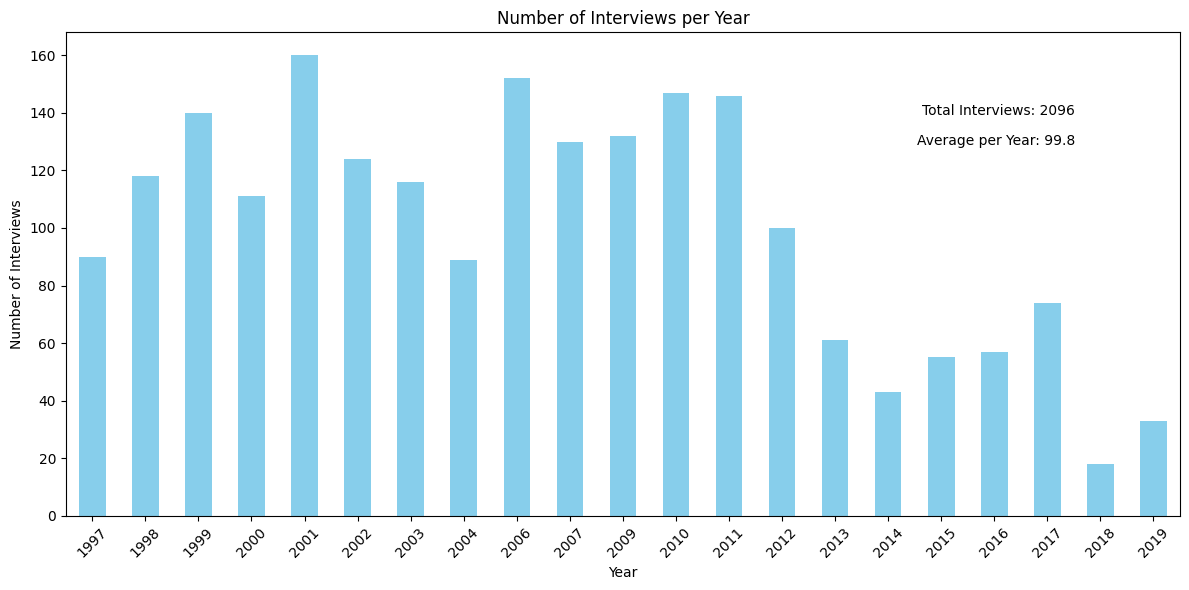

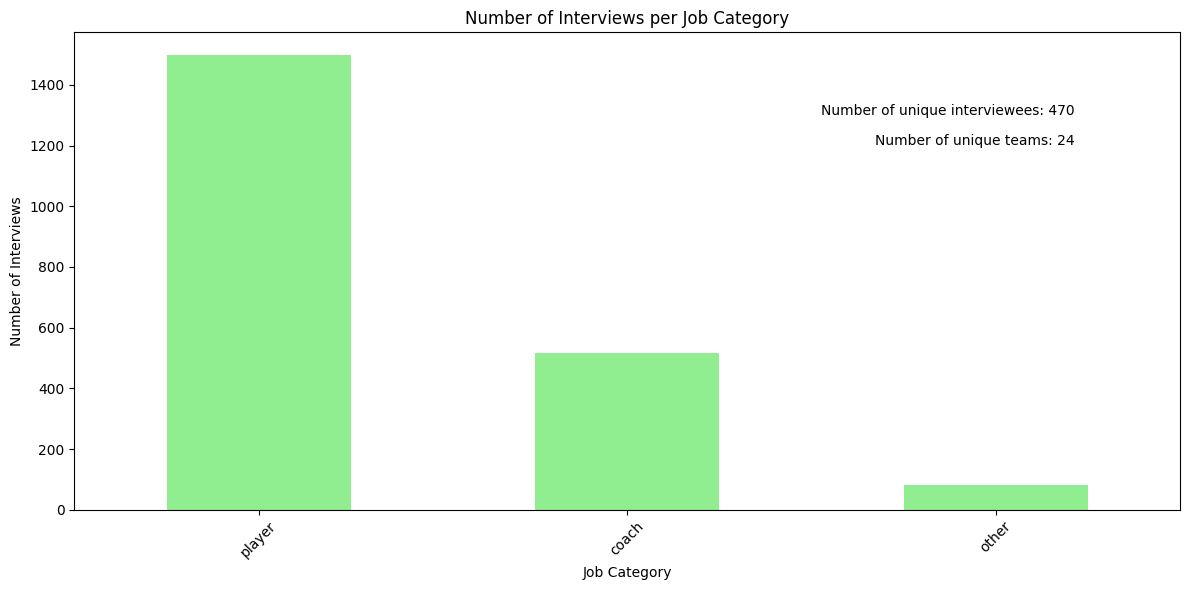

In [8]:
import matplotlib.pyplot as plt

# Plot number of interviews per year
plt.figure(figsize=(12, 6))
interviews_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Interviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Interviews')
plt.xticks(rotation=45)
plt.figtext(0.9, 0.8, f'Total Interviews: {interviews_per_year.sum()}', fontsize=10, ha='right')
plt.figtext(0.9, 0.75, f'Average per Year: {average_interviews_per_year:.1f}', fontsize=10, ha='right')
plt.tight_layout()
plt.show()

# Plot number of interviews per job category
plt.figure(figsize=(12, 6))
interviews_per_job.plot(kind='bar', color='lightgreen')
plt.title('Number of Interviews per Job Category')
plt.xlabel('Job Category')
plt.ylabel('Number of Interviews')
plt.xticks(rotation=45)
plt.figtext(0.9, 0.8, f'Number of unique interviewees: {total_interviewees}', fontsize=10, ha='right')
plt.figtext(0.9, 0.75, f'Number of unique teams: {len(total_teams)}', fontsize=10, ha='right')
plt.tight_layout()
plt.show()

## Step 4: Start Preprocessing

In [9]:
import spacy
# Load the small English model, disabling some components that we don't need right now
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])

# Take an example sentence and print every token from it separately
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project

Apple
is
looking
at
buying
U.K.
startup
for
$
1
billion


#### Text Preprocessing:
* Tokenization
* Stop word removal
* Lemmatization

In [10]:
# FOR LATER USE

def preprocess(text):
    # Step 1: Tokenize the text
    tokens = nlp(text)
    # Step 2: Remove stop words and non-alphabetic tokens, and lemmatize
    tokens = [token.lemma_ for token in tokens if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

In [11]:
# Test
text = df.iloc[2]['text']
print(text)
text = preprocess(text)
print(text)

that's a good question i don't recall specific moment really with that being said i played against them quite a bit knowing that there's a lot of pride in this room a lot of character they're going to keep battling no matter what something nice to be on that side antoine vermette i think that was a great illustration on that goal with the way we try to play try to establish our speed and moving our feet especially in their end i think on that play it was great work teuvo kept it working hard create a turnover and we got the puck in the slot
good question recall specific moment say play bit know lot pride room lot character go battle matter nice antoine vermette think great illustration goal way try play try establish speed move foot especially end think play great work teuvo keep work hard create turnover get puck slot


#### Data Splitting
We will split the dataset into training and testing sets using an 70-30 split.

In [12]:
train = df.sample(frac=0.7, random_state=123456789) # seed for reproducibility
test = df.drop(train.index)

## Step 5: Model Definition Building

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

def train_and_evaluate(train, test, vectorizer, model):
    # when creating pipe, scitkit-learn automatically handles fit & transform = efficiency :)
    pipe = Pipeline([("vect", vectorizer), ("model", model)])
    pipe_fit = pipe.fit(train['text'], train['job']) # x = text = input, y = job = target
    y_pred = pipe_fit.predict(test['text'])
    print(classification_report(test['job'], y_pred))

## Step 6: Train and Evaluate Classification Models

**Classification Models**
We will train several **classification models** to predict the job category of the interviewee based on the text of the interview. The models we will use include:
- Multinomial naive bayes
- Multinomial logistic regression
- Decision trees
- Random forests
- Gradient boosting
- K-neighbours
- DistilBERT?
- LLM

**Vectorization Methods**
The models need to convert text data into numerical features. This is called vectorization. This research will explore two **vectorization methods**:
- Count Vectorizer
- TF-IDF Vectorizer

**Evaluation Metrics**
The models need to be evaluated using appropriate metrics. We will use the following **evaluation metrics**, all with weighted averages:
- Accuracy
- Precision
- Recall
- F1-score

### Baseline - most frequent class

In [14]:
from sklearn.dummy import DummyClassifier

# when creating pipe, scitkit-learn automatically handles fit & transform = efficiency :)
pipe = Pipeline([("dummy", DummyClassifier(strategy = 'most_frequent'))])
pipe_fit = pipe.fit(train['text'], train['job']) # x = text = input, y = job = target
y_pred = pipe_fit.predict(test['text'])
print(classification_report(test['job'], y_pred))

              precision    recall  f1-score   support

       coach       0.00      0.00      0.00       140
       other       0.00      0.00      0.00        26
      player       0.74      1.00      0.85       463

    accuracy                           0.74       629
   macro avg       0.25      0.33      0.28       629
weighted avg       0.54      0.74      0.62       629



/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

### Multinomial Naive Bayes - Count Vectorizer

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# NO REMOVAL OF STOP WORDS
train_and_evaluate(train, test, CountVectorizer(stop_words=None), MultinomialNB())

# REMOVAL OF ENGLISH STOP WORDS
train_and_evaluate(train, test, CountVectorizer(stop_words='english'), MultinomialNB())

              precision    recall  f1-score   support

       coach       0.75      0.89      0.81       140
       other       0.78      0.54      0.64        26
      player       0.95      0.91      0.93       463

    accuracy                           0.89       629
   macro avg       0.83      0.78      0.79       629
weighted avg       0.90      0.89      0.89       629

              precision    recall  f1-score   support

       coach       0.77      0.86      0.81       140
       other       0.88      0.54      0.67        26
      player       0.94      0.93      0.94       463

    accuracy                           0.90       629
   macro avg       0.86      0.78      0.81       629
weighted avg       0.90      0.90      0.90       629



#### Interpretation of Results

**`stop_words=None`** (which is the default) means **no stop words are removed**. The vectorizer keeps every single word, including common ones like "the", "is", "and", etc.

1. **First Run (`stop_words=None`)**:
- **Accuracy: 89%**. Even with all the "noise" words ("the", "a", "is"), the model performed quite well. This is common in Naive Bayes because the frequency of these words might be roughly the same across classes, so they cancel out, or the specific "hockey words" are strong enough signals on their own.

2. **Second Run (`stop_words='english'`)**:
- **Accuracy: 90%**. Removing the common English stop words improved the model slightly (from 89% to 90%).
- **Why?** By removing generic words, the model could focus more on the meaningful content words (like "puck", "strategy", "team") that actually distinguish a coach from a player. 
- The **Macro Avg F1-score** jumped from 0.79 to 0.81, indicating better performance across the minority classes (Coach/Other).

### Multinomial Naive Bayes - TF-IDF Vectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Standard tf-idf vectorizer
train_and_evaluate(train, test, TfidfVectorizer(), MultinomialNB())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train, test, TfidfVectorizer(analyzer=preprocess), MultinomialNB())

/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

              precision    recall  f1-score   support

       coach       0.00      0.00      0.00       140
       other       0.00      0.00      0.00        26
      player       0.74      1.00      0.85       463

    accuracy                           0.74       629
   macro avg       0.25      0.33      0.28       629
weighted avg       0.54      0.74      0.62       629

              precision    recall  f1-score   support

       coach       0.00      0.00      0.00       140
       other       0.00      0.00      0.00        26
      player       0.74      1.00      0.85       463

    accuracy                           0.74       629
   macro avg       0.25      0.33      0.28       629
weighted avg       0.54      0.74      0.62       629



/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

#### Interpretation of Results
* The model is predicting "player" for every single test case.
* Need to balance the classes first. The model simply learns to predict the majority class otherwise.

**Differences between CountVectorizer and TfidfVectorizer**
1. **CountVectorizer (Bag of Words)**:
- Mechanism: Counts the absolute frequency of each word in a document.
- Result: If the word "hockey" appears 5 times, its feature value is 5.
- Drawback: Common words (like "the", "a", "is") often have the highest counts, potentially overshadowing rare but important words unless you explicitly remove stop words.
2. **TfidfVectorizer (Term Frequency - Inverse Document Frequency)**:

- Mechanism: Weighs words based on how unique they are to a specific document.
    - TF: How often the word appears in this document.
    - IDF: Penalizes words that appear in many documents across the dataset.
- Result: A word like "the" (high document frequency) gets a very low score close to 0. A specific name like "Gretzky" (low document frequency) gets a high score.
- Expected Output: Generally provides better accuracy for classification because it automatically down-weights non-informative common words and normalizes for document length.

### Create a balanced dataset

In [18]:
# Undersampling

# completely remove 'other' class, filter train set
train_filtered = train[train['job'] != 'other']
least_common_count = train_filtered['job'].value_counts().min()
train_balanced = train_filtered.groupby('job').apply(lambda x: x.sample(least_common_count, random_state=123456789)).reset_index(drop=True)
test_without_other = test[test['job'] != 'other']

print(train_balanced['job'].value_counts())
print(test_without_other['job'].value_counts())


job
coach     375
player    375
Name: count, dtype: int64
job
player    463
coach     140
Name: count, dtype: int64


/var/folders/s9/kdv9nl2572zd_6njjnd94dz00000gn/T/ipykernel_28614/2143067600.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_balanced = train_filtered.groupby('job').apply(lambda x: x.sample(least_common_count, random_state=123456789)).reset_index(drop=True)


#### Why not balance the test set?
* The test set should represent real-world data distribution as closely as possible.
* The real world is imbalanced (there are far more players than coaches). If the test set is balanced, you are evaluating the model on a fake scenario that doesn't exist.
* The goal is to evaluate how well the model generalizes to the real-world scenario, where class distributions are often imbalanced.

**After undersampling**:
* Train players: 375
* Test players: 463
* Ratio: almost 40/60.

This is **not a problem** since this is the tradfe-off of undersampling; you sacrifice data quantity to gain class balance.

### Multinomial Naive Bayes - Count Vectorizer - Balanced Dataset

In [19]:
train_and_evaluate(train_balanced, test_without_other, CountVectorizer(), MultinomialNB())

              precision    recall  f1-score   support

       coach       0.55      0.96      0.70       140
      player       0.99      0.76      0.86       463

    accuracy                           0.81       603
   macro avg       0.77      0.86      0.78       603
weighted avg       0.88      0.81      0.82       603



### Multinomial Naive Bayes - TF-IDF Vectorizer - Balanced Dataset

In [20]:
# Standard tf-idf vectorizer
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(), MultinomialNB())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(analyzer=preprocess), MultinomialNB())

              precision    recall  f1-score   support

       coach       0.25      1.00      0.39       140
      player       1.00      0.07      0.13       463

    accuracy                           0.29       603
   macro avg       0.62      0.54      0.26       603
weighted avg       0.82      0.29      0.19       603

              precision    recall  f1-score   support

       coach       0.31      0.69      0.42       140
      player       0.85      0.53      0.66       463

    accuracy                           0.57       603
   macro avg       0.58      0.61      0.54       603
weighted avg       0.72      0.57      0.60       603



### Multinomial Logistic Regression - Count Vectorizer

In [24]:
from sklearn.linear_model import LogisticRegression

train_and_evaluate(train, test, CountVectorizer(), LogisticRegression(solver='lbfgs'))

/Users/axelstrid/Desktop/TDDE16/TDDE16-Text-Mining-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       coach       0.88      0.85      0.86       140
       other       0.59      0.38      0.47        26
      player       0.94      0.97      0.95       463

    accuracy                           0.92       629
   macro avg       0.80      0.73      0.76       629
weighted avg       0.91      0.92      0.91       629



### Multinomial Logistic Regression - TF-IDF Vectorizer

In [40]:
from sklearn.linear_model import LogisticRegression

# Standard tf-idf vectorizer
train_and_evaluate(train, test, TfidfVectorizer(), LogisticRegression(solver='lbfgs'))

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train, test, TfidfVectorizer(analyzer=preprocess), LogisticRegression(solver='lbfgs'))

              precision    recall  f1-score   support

       coach       0.86      0.85      0.85       140
       other       0.88      0.27      0.41        26
      player       0.93      0.97      0.95       463

    accuracy                           0.91       629
   macro avg       0.89      0.70      0.74       629
weighted avg       0.91      0.91      0.91       629

              precision    recall  f1-score   support

       coach       0.00      0.00      0.00       140
       other       0.80      0.15      0.26        26
      player       0.74      1.00      0.85       463

    accuracy                           0.74       629
   macro avg       0.51      0.38      0.37       629
weighted avg       0.58      0.74      0.64       629



### Multinomial Logistic Regression - TF-IDF Vectorizer - Balanced Dataset

In [26]:
# Standard tf-idf vectorizer
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(), LogisticRegression(solver='lbfgs'))

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(analyzer=preprocess), LogisticRegression(solver='lbfgs'))

              precision    recall  f1-score   support

       coach       0.75      0.95      0.84       140
      player       0.98      0.90      0.94       463

    accuracy                           0.91       603
   macro avg       0.87      0.93      0.89       603
weighted avg       0.93      0.91      0.92       603

              precision    recall  f1-score   support

       coach       0.38      0.71      0.49       140
      player       0.88      0.64      0.74       463

    accuracy                           0.66       603
   macro avg       0.63      0.68      0.62       603
weighted avg       0.76      0.66      0.68       603



### Decision Trees - Count Vectorizer

In [27]:
from sklearn.tree import DecisionTreeClassifier

train_and_evaluate(train, test, CountVectorizer(), DecisionTreeClassifier())

              precision    recall  f1-score   support

       coach       0.71      0.74      0.72       140
       other       0.39      0.35      0.37        26
      player       0.90      0.90      0.90       463

    accuracy                           0.84       629
   macro avg       0.67      0.66      0.66       629
weighted avg       0.84      0.84      0.84       629



### Decision Trees - TF-IDF Vectorizer

In [28]:
# Standard tf-idf vectorizer
train_and_evaluate(train, test, TfidfVectorizer(), DecisionTreeClassifier())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train, test, TfidfVectorizer(analyzer=preprocess), DecisionTreeClassifier())

              precision    recall  f1-score   support

       coach       0.64      0.63      0.64       140
       other       0.42      0.38      0.40        26
      player       0.87      0.88      0.88       463

    accuracy                           0.80       629
   macro avg       0.64      0.63      0.64       629
weighted avg       0.80      0.80      0.80       629

              precision    recall  f1-score   support

       coach       0.51      0.55      0.53       140
       other       0.35      0.42      0.39        26
      player       0.85      0.82      0.83       463

    accuracy                           0.74       629
   macro avg       0.57      0.60      0.58       629
weighted avg       0.75      0.74      0.75       629



### Decision Trees - Count Vectorizer - Balanced Dataset

In [29]:
# Standard tf-idf vectorizer
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(), DecisionTreeClassifier())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(analyzer=preprocess), DecisionTreeClassifier())

              precision    recall  f1-score   support

       coach       0.51      0.77      0.61       140
      player       0.92      0.77      0.84       463

    accuracy                           0.77       603
   macro avg       0.71      0.77      0.73       603
weighted avg       0.82      0.77      0.79       603

              precision    recall  f1-score   support

       coach       0.43      0.69      0.53       140
      player       0.89      0.72      0.80       463

    accuracy                           0.72       603
   macro avg       0.66      0.71      0.66       603
weighted avg       0.78      0.72      0.74       603



### Random Forsts - Count Vectorizer

In [30]:
from sklearn.ensemble import RandomForestClassifier

train_and_evaluate(train, test, CountVectorizer(), RandomForestClassifier())

              precision    recall  f1-score   support

       coach       0.75      0.70      0.73       140
       other       1.00      0.35      0.51        26
      player       0.89      0.94      0.92       463

    accuracy                           0.86       629
   macro avg       0.88      0.66      0.72       629
weighted avg       0.87      0.86      0.86       629



### Random Forests - TF-IDF Vectorizer

In [31]:
# Standard tf-idf vectorizer
train_and_evaluate(train, test, TfidfVectorizer(), RandomForestClassifier())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train, test, TfidfVectorizer(analyzer=preprocess), RandomForestClassifier())

              precision    recall  f1-score   support

       coach       0.89      0.63      0.74       140
       other       1.00      0.27      0.42        26
      player       0.88      0.99      0.93       463

    accuracy                           0.88       629
   macro avg       0.92      0.63      0.70       629
weighted avg       0.88      0.88      0.87       629

              precision    recall  f1-score   support

       coach       0.77      0.59      0.67       140
       other       0.89      0.31      0.46        26
      player       0.86      0.95      0.90       463

    accuracy                           0.84       629
   macro avg       0.84      0.62      0.68       629
weighted avg       0.84      0.84      0.83       629



### Random Forests - TF-IDF Vectorizer - Balanced Dataset

In [32]:
# Standard tf-idf vectorizer
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(), RandomForestClassifier())

# tf-idf vectorizer with manual preprocessing
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(analyzer=preprocess), RandomForestClassifier())

              precision    recall  f1-score   support

       coach       0.66      0.85      0.75       140
      player       0.95      0.87      0.91       463

    accuracy                           0.87       603
   macro avg       0.81      0.86      0.83       603
weighted avg       0.88      0.87      0.87       603

              precision    recall  f1-score   support

       coach       0.65      0.79      0.71       140
      player       0.93      0.87      0.90       463

    accuracy                           0.85       603
   macro avg       0.79      0.83      0.81       603
weighted avg       0.87      0.85      0.86       603



### Gradient Boosting - Count Vectorizer

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
train_and_evaluate(train, test, CountVectorizer(), GradientBoostingClassifier())

              precision    recall  f1-score   support

       coach       0.87      0.83      0.85       140
       other       0.75      0.35      0.47        26
      player       0.93      0.97      0.95       463

    accuracy                           0.91       629
   macro avg       0.85      0.71      0.76       629
weighted avg       0.90      0.91      0.90       629



### Gradient Boosting - TF-IDF Vectorizer

In [34]:
# Standard tf-idf vectorizer
train_and_evaluate(train, test, TfidfVectorizer(), GradientBoostingClassifier())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train, test, TfidfVectorizer(analyzer=preprocess), GradientBoostingClassifier())

              precision    recall  f1-score   support

       coach       0.85      0.82      0.84       140
       other       0.88      0.27      0.41        26
      player       0.92      0.97      0.94       463

    accuracy                           0.91       629
   macro avg       0.88      0.69      0.73       629
weighted avg       0.90      0.91      0.90       629

              precision    recall  f1-score   support

       coach       0.75      0.66      0.70       140
       other       0.86      0.46      0.60        26
      player       0.88      0.94      0.91       463

    accuracy                           0.86       629
   macro avg       0.83      0.69      0.74       629
weighted avg       0.85      0.86      0.85       629



### Gradient Boosting - TF-IDF Vectorizer - Balanced Dataset

In [35]:
# Standard tf-idf vectorizer
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(), GradientBoostingClassifier())

# tf-idf vectorizer with manual preprocessing
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(analyzer=preprocess), GradientBoostingClassifier())

              precision    recall  f1-score   support

       coach       0.76      0.91      0.83       140
      player       0.97      0.91      0.94       463

    accuracy                           0.91       603
   macro avg       0.87      0.91      0.88       603
weighted avg       0.92      0.91      0.91       603

              precision    recall  f1-score   support

       coach       0.62      0.81      0.71       140
      player       0.94      0.85      0.89       463

    accuracy                           0.84       603
   macro avg       0.78      0.83      0.80       603
weighted avg       0.86      0.84      0.85       603



### K-Neighbors - Count Vectorizer

In [36]:
from sklearn.neighbors import KNeighborsClassifier
train_and_evaluate(train, test, CountVectorizer(), KNeighborsClassifier())

              precision    recall  f1-score   support

       coach       0.79      0.74      0.76       140
       other       0.47      0.31      0.37        26
      player       0.90      0.93      0.92       463

    accuracy                           0.86       629
   macro avg       0.72      0.66      0.68       629
weighted avg       0.86      0.86      0.86       629



### K-Neigbhors - TF-IDF Vectorizer

In [37]:
# Standard tf-idf vectorizer
train_and_evaluate(train, test, TfidfVectorizer(), KNeighborsClassifier())

# tf-idf vectorizer with manual prepocessing
train_and_evaluate(train, test, TfidfVectorizer(analyzer=preprocess), KNeighborsClassifier())

              precision    recall  f1-score   support

       coach       0.28      1.00      0.44       140
       other       0.92      0.46      0.62        26
      player       0.99      0.27      0.42       463

    accuracy                           0.44       629
   macro avg       0.73      0.58      0.49       629
weighted avg       0.83      0.44      0.43       629

              precision    recall  f1-score   support

       coach       0.42      0.89      0.57       140
       other       0.92      0.42      0.58        26
      player       0.93      0.64      0.76       463

    accuracy                           0.69       629
   macro avg       0.76      0.65      0.64       629
weighted avg       0.82      0.69      0.71       629



### K-Neigbors - TF-IDF Vectorizer - Balanced Dataset

In [38]:
# Standard tf-idf vectorizer
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(), KNeighborsClassifier())

# tf-idf vectorizer with manual preprocessing
train_and_evaluate(train_balanced, test_without_other, TfidfVectorizer(analyzer=preprocess), KNeighborsClassifier())

              precision    recall  f1-score   support

       coach       0.25      1.00      0.40       140
      player       1.00      0.09      0.17       463

    accuracy                           0.30       603
   macro avg       0.62      0.55      0.28       603
weighted avg       0.83      0.30      0.22       603

              precision    recall  f1-score   support

       coach       0.30      0.96      0.45       140
      player       0.97      0.30      0.46       463

    accuracy                           0.46       603
   macro avg       0.63      0.63      0.46       603
weighted avg       0.81      0.46      0.46       603



## Step 8: Zero-shot comparison with LLM

### Gemini API call to flash-2.5

This compares the supervised classifier models against a generic LLM that has not been trained on this specific dataset.

`pip install google-generative-ai`

In [ ]:
import google.generativeai as genai
import time
from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

# Set up the API key to Gemini
API_KEY = os.getenv("API_KEY")
genai.configure(api_key=API_KEY)

# Build the classification function
def classify_with_gemini(text, model_name='gemini-2.5-flash'):
    # Instantiate model
    model = genai.GenerativeModel(model_name)
    
    # Zero-shot Prompt
    prompt = f"""
    You are an expert NHL hockey analyst. Read the following interview transcript.
    Determine if the speaker is a 'coach' or a 'player' or 'other'.
    
    Rules:
    1. Answer ONLY with the word 'coach' or 'player' or 'other'.
    2. Do not add punctuation or explanation.
    3. If it is ambiguous, guess the most likely role based on hockey terminology (e.g. coaches talk about 'we' as the system/group, players talk about 'I' or specific on-ice actions).

    Transcript:
    "{text[:2000]}" 
    """
    # Note: We truncate text to 2000 chars to save tokens, usually enough for classification
    
    response = model.generate_content(prompt)
    # Clean response (remove whitespace, lower case)
    prediction = response.text.strip().lower()
    return prediction

# Run on a subset of 50 randmom samples from the test set
sample_size = 50
test_subset = test.sample(sample_size, random_state=123456789)

print(f"Running Gemini classification on {sample_size} samples...")

# Apply function to the samples
predictions = []
for text in test_subset['text']:
    pred = classify_with_gemini(text)
    predictions.append(pred)
    time.sleep(1.0) # 1 second delay between requests to avoid rate limiting

test_subset['gemini_pred'] = predictions

# Evaluate
print("\n--- Gemini Zero-Shot Classification Report ---")
print(classification_report(test_subset['job'], test_subset['gemini_pred']))

Running Gemini classification on 50 samples...

--- Gemini Zero-Shot Classification Report ---
              precision    recall  f1-score   support

       coach       0.76      0.93      0.84        14
       other       0.00      0.00      0.00         1
      player       1.00      0.91      0.96        35

    accuracy                           0.90        50
   macro avg       0.59      0.61      0.60        50
weighted avg       0.91      0.90      0.90        50

